In [1]:
import matplotlib.pyplot as plt
import json

import numpy as np
import random
import copy
from collections import namedtuple, deque
from model import Actor, Critic
from agent import Agent
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name='./Reacher_Linux20/Reacher.x86_64')



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents, env_info.vector_observations.shape[0])

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

print(states[0].shape, states[0,:].shape)

Number of agents: 20 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
(33,) (33,)


In [6]:
#Actor and Critic Networks
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.elu(self.fc1(state))
        x = F.elu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.elu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.elu(self.fc2(x))
        return self.fc3(x)

In [7]:
#Agent
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4 #3e-5 #1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4 #3e-5 #1e-4        # learning rate of the critic
WEIGHT_DECAY_actor = 0.0 #3e-4 #0        # L2 weight decay
WEIGHT_DECAY_critic = 0.0 #1e-6 #0        # L2 weight decay

#to decay exploration as it learns
EPS_START=1.0
EPS_END=0.05
EPS_DECAY=3e-5

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY_critic)

        # Noise process
        #self.noise = OUNoise(action_size, random_seed) #single agent only
        self.noise = OUNoise((num_agents, action_size), random_seed) #both singe and multiple agent
        self.eps = EPS_START

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
        # Make sure target is initialized with the same weight as the source (found on slack to make big difference)
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)


    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        #Experience from each agent is separately saved (so it works for single or multi agent environment)
        #This works because each agent is operating in a separate/independent environment
        for a in range(self.num_agents):
            self.memory.add(states[a], actions[a], rewards[a], next_states[a], dones[a])

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        #add noise according to epsilon probability
        if add_noise and (np.random.random() < self.eps):
            actions += self.noise.sample()
            #update the exploration parameter
            self.eps -= EPS_DECAY
            if self.eps < EPS_END:
                self.eps = EPS_END
            #self.noise.reset() #not sure if need to do this here

        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1.0) #clip the gradient for the critic network (Udacity hint)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


    ## from slack - Since you're using DDPG, @gregoriomezquita mentioned that 
    ## initializing the weights of the target networks to be the same as those 
    ## of the live networks seemed to make a huge difference
    def hard_update(self, target, source):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, 
 
              num_agents=env_info.vector_observations.shape[0],  random_seed=0)
#Agent
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4 #3e-5 #1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4 #3e-5 #1e-4        # learning rate of the critic
WEIGHT_DECAY_actor = 0.0 #3e-4 #0        # L2 weight decay
WEIGHT_DECAY_critic = 0.0 #1e-6 #0        # L2 weight decay

#to decay exploration as it learns
EPS_START=1.0
EPS_END=0.05
EPS_DECAY=3e-5



#for single and multiple agents
def ddpg(n_episodes=2000):
    scores_deque = deque(maxlen=100)
    scores_list = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        agent.reset() #reset the agent OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get rewards (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent)
            agent.step(states, actions, rewards, next_states, dones) #train the agent         
            # Extra Learning per time step (since generating so much experience at each step)
            if len(agent.memory) > BATCH_SIZE:
                for _ in range(3):
                    experiences = agent.memory.sample()
                    agent.learn(experiences, GAMMA)
                    
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        scores_deque.append(np.mean(scores))
        scores_list.append(np.mean(scores))
        
        #print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {}'.format(i_episode, np.mean(scores_deque), score), end="")
        print('Episode {}\tAverage Score: {:.2f}\tScore: {}'.format(i_episode, np.mean(scores_deque), np.mean(scores)))
        print('Epsilon: {} and Memory size: {}'.format(agent.eps, len(agent.memory)))
        
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) > 30 and len(scores_deque) >= 100:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
            
    return scores_list

In [8]:
scores = ddpg()

/home/surajit/Desktop/deep-reinforcement-learning/control_ball/agent.py:128: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1.0) #clip the gradient for the critic network (Udacity hint)


Episode 1	Average Score: 0.57	Score: 0.5674999873153865
Epsilon: 0.970540000000025 and Memory size: 20020
Episode 2	Average Score: 0.67	Score: 0.7699999827891588
Epsilon: 0.9419200000000494 and Memory size: 40040
Episode 3	Average Score: 0.78	Score: 0.995499977748841
Epsilon: 0.9137800000000733 and Memory size: 60060
Episode 4	Average Score: 1.04	Score: 1.8249999592080712
Epsilon: 0.8869000000000962 and Memory size: 80080
Episode 5	Average Score: 1.28	Score: 2.2554999495856465
Epsilon: 0.8610400000001182 and Memory size: 100000
Episode 6	Average Score: 1.49	Score: 2.5349999433383346
Epsilon: 0.8358700000001396 and Memory size: 100000
Episode 7	Average Score: 1.68	Score: 2.7854999377392233
Epsilon: 0.8113600000001604 and Memory size: 100000
Episode 8	Average Score: 1.87	Score: 3.207499928306788
Epsilon: 0.7880200000001802 and Memory size: 100000
Episode 9	Average Score: 2.10	Score: 3.9674999113194644
Epsilon: 0.7645000000002002 and Memory size: 100000
Episode 10	Average Score: 2.38	Scor

Episode 77	Average Score: 28.76	Score: 38.203499146085235
Epsilon: 0.09856000000062637 and Memory size: 100000
Episode 78	Average Score: 28.87	Score: 37.086499171052125
Epsilon: 0.09541000000062613 and Memory size: 100000
Episode 79	Average Score: 29.00	Score: 38.91299913022667
Epsilon: 0.09277000000062594 and Memory size: 100000
Episode 80	Average Score: 29.12	Score: 38.85199913159013
Epsilon: 0.09034000000062575 and Memory size: 100000
Episode 81	Average Score: 29.24	Score: 38.56899913791567
Epsilon: 0.08788000000062557 and Memory size: 100000
Episode 82	Average Score: 29.35	Score: 38.672499135602266
Epsilon: 0.08494000000062535 and Memory size: 100000
Episode 83	Average Score: 29.45	Score: 37.79599915519357
Epsilon: 0.08257000000062517 and Memory size: 100000
Episode 84	Average Score: 29.55	Score: 37.770999155752364
Epsilon: 0.08008000000062498 and Memory size: 100000
Episode 85	Average Score: 29.64	Score: 36.81949917702004
Epsilon: 0.07795000000062483 and Memory size: 100000
Episod

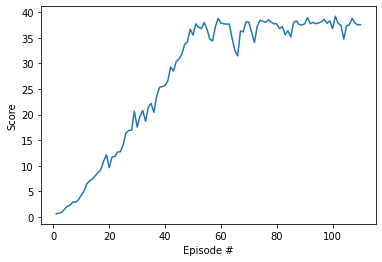

In [10]:
with open("scores_file.json", "w") as write_file:
        json.dump(scores, write_file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, 
              num_agents=env_info.vector_observations.shape[0],  random_seed=0)

#Since the model is trained on gpu, need to load all gpu tensors to cpu:

agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location=lambda storage, loc: storage))
agent.eps = 0.05
scores_list = []
def ddpg_inference(n_episodes=50):
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        agent.reset() #reset the agent OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get rewards (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Episode {}: {}'.format(i_episode, np.mean(scores)))
        scores_list.append(np.mean(scores))
    print('Mean score is: ', np.mean(np.array(scores_list)))
    
ddpg_inference()